## Bike rental predicting model ##

Using data collected by the Washington, DC district on their communal bike rental initiative.

It contains **17,380** rows, where each one represents an hour of rentals during a specific day. Each row has date, yearly season, weather conditions, day of the week and other relevant information that will help us see if we can predict consumer behavior.

Here are the descriptions for the relevant columns:

* **instant** - A unique sequential ID number for each row
* **dteday** - The date of the rentals
* **season** - The season in which the rentals occurred
* **yr** - The year the rentals occurred
* **mnth** - The month the rentals occurred
* **hr** - The hour the rentals occurred
* **holiday** - Whether or not the day was a holiday
* **weekday** - The day of the week (as a number, 0 to 7)
* **workingday** - Whether or not the day was a working day
* **weathersit** - The weather (as a categorical variable)
* **temp** - The temperature, on a 0-1 scale
* **atemp** - The adjusted temperature
* **hum** - The humidity, on a 0-1 scale
* **windspeed** - The wind speed, on a 0-1 scale
* **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* **registered** - The number of registered riders (people who had already signed up)
* **cnt** - The total number of bike rentals (casual + registered)

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
rentals = pd.read_csv('bike_rental_hour.csv')

In [4]:
rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


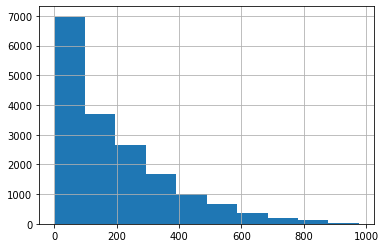

In [5]:
rentals.cnt.hist()

In [6]:
rentals.corr()['cnt'].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Looking at the correlation with the amount of rentals, the top ones are: **registered** usage from people who signed up for the service, **casual** usage from people who hadn't signed to the program and **temp**/**atemp**, which stand for the temperature in raw and adjusted numbers.

Since **cnt** is a count of *both* registred and casual users, it's a no brained those are the most highly correlated. So that means temperature is the single biggest external factor that determines bike usage.

After those, we find **hr**, which refers to the time where the rental occured. Since we want to group the hours so they can have a relevant relation other than number going up/down, we'll define a function to create four groups of hours.

In [7]:
def assign_label(hour):
    if hour <= 6:
        return 4
    elif hour <= 12:
        return 1
    elif hour <= 18:
        return 2
    elif hour <= 24:
        return 3

In [8]:
rentals['time_label'] = rentals['hr'].apply(assign_label)

In [9]:
rentals['time_label'].value_counts()

4    5001
2    4375
1    4363
3    3640
Name: time_label, dtype: int64

Hour labelling went on without issues, so now let's proceed to divide the set into train and test batches.

In [10]:
train = rentals.sample(frac=0.8)

In [11]:
test = rentals.loc[~rentals.index.isin(train.index)]

In [12]:
cols = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
        , 'time_label']

In [13]:
rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [15]:
lr = LinearRegression()
lr.fit(train[cols], train['cnt'])
pred = lr.predict(test[cols])
mse = mean_squared_error(pred, test['cnt'])
rmse = np.sqrt(mse)
print(rmse)

125.74226360145171


In [16]:
train['cnt'].mean(), rentals['cnt'].mean(), test['cnt'].mean(), pred.mean()

(189.54463065525425, 189.46308763450142, 189.13693901035674, 192.7963034159791)

With an RMSE of 125, it seems our model is working really well. We can confirm that if we look at the mean from each dataframe and compare it to the prediction mean. They're all within *less than 3% of each other*.

In [17]:
from sklearn.tree import DecisionTreeRegressor

In [18]:
treemaker = DecisionTreeRegressor(min_samples_leaf=7
)
treemaker.fit(train[cols], train['cnt'])
pred = treemaker.predict(test[cols])
mse = mean_squared_error(pred, test['cnt'])
rmse = np.sqrt(mse)
print(rmse)

49.48426474888024


Using a DecisionTree gives us an error that's twice as accurate as LinearRegression. After fidgeting with *min_samples_leaf*, with a value of 7 arrived at the lowest error we could find: **49.48**

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
forest = RandomForestRegressor(min_samples_leaf=2)
forest.fit(train[cols], train['cnt'])
pred = forest.predict(test[cols])
mse = mean_squared_error(pred, test['cnt'])
rmse = np.sqrt(mse)
print(rmse)

39.82889356808119


With RandomForests, we can lower the error even more. This time, the min_samples_leaf parameter performs better at value 2, which consistently producess an error betwen 42-43.

Let's try to see if we can get it even lower by generating new features. Weather conditions seem to be the biggest factors over bike usage. Rain is a rather obvious parameter, so better to leave it behind. We'll focus on more nuanced metrics such as temperature, humidity and windspeed. We'll add them all together to create the **ambient_index** feature and then will proceed to apply RandomForest again.

In [21]:
rentals['ambient_index'] = rentals[['temp', 'hum', 'windspeed']].sum(axis=1)

In [22]:
train = rentals.sample(frac=0.8)
test = rentals.loc[~rentals.index.isin(train.index)]
cols = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
        , 'time_label', 'ambient_index']

In [23]:
forest = RandomForestRegressor(min_samples_leaf=2)
forest.fit(train[cols], train['cnt'])
pred = forest.predict(test[cols])
mse = mean_squared_error(pred, test['cnt'])
rmse = np.sqrt(mse)
print(rmse)

42.161564887289316


Hmmm. Seems like using this index actually increased the error, but maybe that's because we're being redundant. Let's take out the features that make up the index and try again.

In [24]:
cols = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'atemp', 'time_label', 'ambient_index']

forest = RandomForestRegressor(min_samples_leaf=2)
forest.fit(train[cols], train['cnt'])
pred = forest.predict(test[cols])
mse = mean_squared_error(pred, test['cnt'])
rmse = np.sqrt(mse)
print(rmse)

43.050219489995634


Still the same. Let's take windspeed out of the equation for the index and try again.

In [25]:
rentals['temp_index'] = rentals[['temp', 'atemp', 'hum']].sum(axis=1)

In [26]:
train = rentals.sample(frac=0.8)
test = rentals.loc[~rentals.index.isin(train.index)]
cols = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'atemp', 'time_label', 'temp_index']

forest = RandomForestRegressor(min_samples_leaf=2)
forest.fit(train[cols], train['cnt'])
pred = forest.predict(test[cols])
mse = mean_squared_error(pred, test['cnt'])
rmse = np.sqrt(mse)
print(rmse)

40.61575748986583


Okay! Seems like the *temp_index* really worked. While now the model is not as steady as the initial RandomForest, as it sometimes goes above the initial results, it also can go lower. Even as low as 39-40 as in this case.

Now let's see the effect these conditions have on *casual* and *registered* users.

In [27]:
forest = RandomForestRegressor(min_samples_leaf=2)
forest.fit(train[cols], train['casual'])
pred = forest.predict(test[cols])
mse = mean_squared_error(pred, test['casual'])
rmse = np.sqrt(mse)
print(rmse)

13.3689274842569


In [28]:
forest = RandomForestRegressor(min_samples_leaf=2)
forest.fit(train[cols], train['registered'])
pred = forest.predict(test[cols])
mse = mean_squared_error(pred, test['registered'])
rmse = np.sqrt(mse)
print(rmse)

34.4857181706433


Seems the model is more than *twice* as good at predicting behaviour from casual users than registered ones. Seeing how, at 34, the error for registered ones is a bit lower than our last general run and how, at 13, the error for casual users is *much* lower, we can conclude that registered users are less affected by these conditions, as sometimes they can still go biking even if they take place. Meanwhile, **casual users are just as fickle as the weather itself.**